# Natural images CT Inverse problems with Gaussian Noise


In [17]:
#For plotting and importing images from directories
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Deep inverse imports
import deepinv as dinv
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.models import DnCNN, DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder


torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


In [18]:
path = "data/butterfly.png"
image = Image.open(path)
image = image.convert('L')
transform = transforms.Compose([transforms.ToTensor(),])
img = transform(image)
img.reshape(1, 1, 2048, 1536)

tensor([[[[0.8667, 0.8667, 0.8706,  ..., 0.3843, 0.3882, 0.3922],
          [0.8667, 0.8667, 0.8706,  ..., 0.3882, 0.3961, 0.4000],
          [0.8706, 0.8706, 0.8706,  ..., 0.4000, 0.4078, 0.4118],
          ...,
          [0.6118, 0.6039, 0.6000,  ..., 0.5059, 0.4980, 0.4941],
          [0.6000, 0.5961, 0.5922,  ..., 0.4941, 0.4863, 0.4784],
          [0.5961, 0.5922, 0.5922,  ..., 0.4902, 0.4784, 0.4706]]]])

C:\Users\as5057\AppData\Local\Temp\ipykernel_25192\2576764168.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x1, device=device, dtype=torch.float)


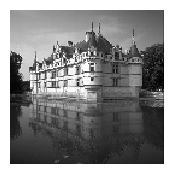

In [19]:
url = get_image_url("CBSD_0010.png")
x1 = load_url_image(url, grayscale = True).to(device)
x = torch.tensor(x1, device=device, dtype=torch.float)
x = torch.nn.functional.interpolate(x, size=(128, 128))
img_size = x.shape[1:]

plot(x)

# Radon Transform with Gaussian noise


In [27]:
noise_level = 0.1
radon = dinv.physics.Tomography(
    img_width = img_size[-1],
    angles = 100,
    device = device,
    noise_model = dinv.physics.GaussianNoise(sigma = noise_level)
)

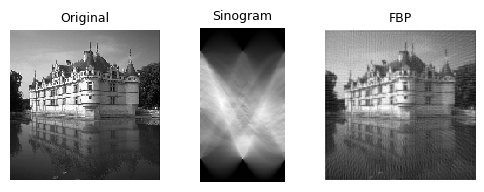

In [28]:
y = radon(x)
fbp = radon.A_dagger(y)
plot([x, y, fbp], titles = ["Original", "Sinogram", "FBP"])

In [74]:
img = x.permute(1, 2, 0).numpy()
plt.imshow(img)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [29]:
params = {"stepsize": 0.01, "lambda": 1, "g_param": noise_level}
params1 = {"stepsize": 0.01, "lambda": 1e-1, "g_param": noise_level}
params2 = {"stepsize": 0.01, "lambda": 1e+1, "g_param": noise_level}
params3 = {"stepsize": 0.01, "lambda": 1e+2, "g_param": noise_level}
max_iter = 50
channels = 1
forward = L2()

# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)

# Classical priors
tvprior = dinv.optim.prior.TVPrior(n_it_max = max_iter)
bm3dprior = dinv.models.BM3D()


In [30]:
priorbm3d = PnP(denoiser = bm3dprior)
prior1 = PnP(denoiser = dncnn)
prior2 = PnP(denoiser = drunet)


# Initialise models (TV, BM3D, DnCNN, DRUNet)

In [31]:
model1 = optim_builder(
    iteration="PGD",
    prior= tvprior,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

#DnCNN
model2 = optim_builder(
    iteration="PGD",
    prior= prior1,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)


#DRUNet
model3 = optim_builder(
    iteration="PGD",
    prior= prior2,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

modelbm3d = optim_builder(
    iteration="PGD",
    prior= priorbm3d,
    data_fidelity = L2(),
    early_stop = True,
    max_iter = max_iter,
    verbose = True,
    params_algo=params,
    custom_init=lambda y, radon: {
        "est": (radon.A_adjoint(y), radon.A_adjoint(y))
    },
)

In [32]:
x_model1, metrics1 = model1(y, radon, x_gt = x, compute_metrics = True)
x_model2, metrics2 = model2(y, radon, x_gt = x, compute_metrics = True)
x_model3, metrics3 = model3(y, radon, x_gt = x, compute_metrics = True)
x_modelbm3d, metricsbm3d = modelbm3d(y, radon, x_gt = x, compute_metrics = True)

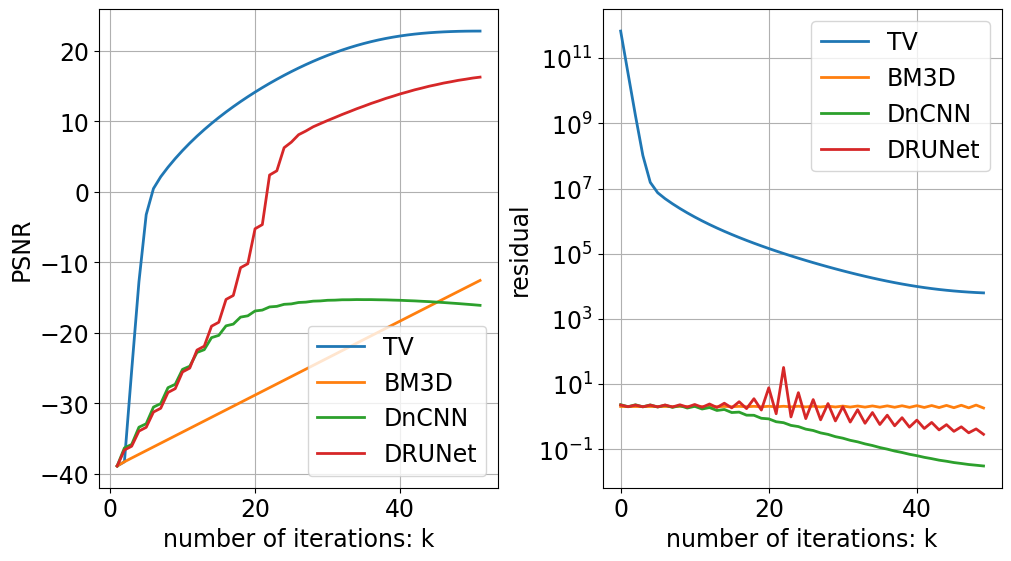

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
def plot_psnrs_residuals(lists, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """


    psnrs = list(lists.values())[0]
    residuals = list(lists.values())[1]
    psnrs = np.array(psnrs).flatten()
    residuals = np.array(residuals).flatten()
    #fig.suptitle(method)
    ax1.plot(range(1, len(psnrs) + 1), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(residuals, label = method)
    ax2.set_ylabel('residual')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)

plot_psnrs_residuals(metrics1, 'TV')
plot_psnrs_residuals(metricsbm3d, 'BM3D')
plot_psnrs_residuals(metrics2, 'DnCNN')
plot_psnrs_residuals(metrics3, 'DRUNet')

ax1.legend()
ax2.legend()


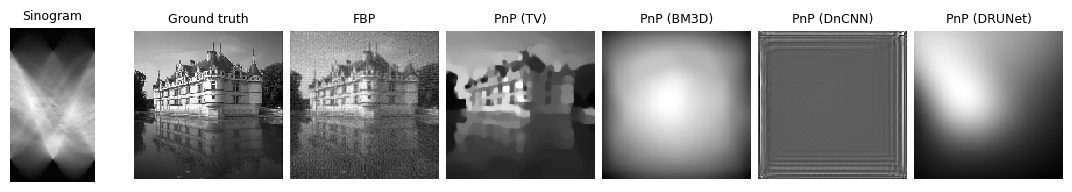

In [26]:
imgs = [y, x, fbp, x_model1, x_modelbm3d, x_model2, x_model3]
plot(imgs, titles = ["Sinogram", "Ground truth", "FBP", "PnP (TV)", "PnP (BM3D)", "PnP (DnCNN)", "PnP (DRUNet)"])